## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display as display
from IPython.core.pylabtools import figsize, getfigs
import math
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
import numpy as np
import cv2
from tqdm import tqdm
   
def draw_image(img, title):
    """ Draw a single image with a title """
    f = plt.figure(figsize=(15, 15))
    plt.title(title)
    plt.imshow(img, cmap='gray')
    display(f)
    plt.close(f)
    
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def draw_grid(imgs, title='', img_shape = [100, 100], cols = 2, width = 5):
    rows = math.ceil(len(imgs)/cols)
    fig = plt.figure(figsize=(width, int(0.7*(img_shape[0]*rows)*width/(cols*img_shape[1]))))

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    for i in range(len(imgs)):
        grid[i].imshow(imgs[i], cmap='gray')
    fig.subplots_adjust(hspace=0)    
    plt.suptitle(title)    
    plt.show()
    
def toRGB(img):
    return cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)

In [62]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

def read_images(images):
    out_images = []
    for fname in images:
        img = cv2.imread(fname)
        out_images.append(img)
    return out_images

imgs = read_images(images)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

class Camera:
    def __init__(self):
        self.cameraMatrix = None
        self.distCoeffs = None
        self.rvecs = None
        self.tvecs = None
        self.objpoints = []
        self.imgpoints = []
        
    def calibrate(self, imgs, draw = True):
        for img in tqdm(imgs):
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                if draw == True:
                    # Draw and display the corners
                    outimg = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                    draw_image(outimg, "Chessboard Corners")
                   
        retval, self.cameraMatrix, self.distCoeffs, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, gray.shape, None, None)
   
    def undistort(self, img, draw = False):
        out_img = cv2.undistort(img, self.cameraMatrix, self.distCoeffs, None, self.cameraMatrix)
        if draw == True:
            draw_image(out_img, "Undistorted")
        return out_img
    
    def birdseye_transform(self, img):
        return cv2.warpPerspective(img, M, img.shape[:2][::-1], flags=cv2.INTER_CUBIC)
    
    def birdseye_inverse(self, img):
        return cv2.warpPerspective(img, Minv, img.shape[:2][::-1], flags=cv2.INTER_CUBIC)
    
    def clahe_l(self, img):
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        return final 
    
    def threshold(self, img, s_thresh=(170, 255), sx_thresh=(20, 100)):
        img = np.copy(img)
        # Convert to HSV color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        
        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
        
        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Stack each channel
        # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
        # be beneficial to replace this channel with something else.
        #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
        color_binary = sxbinary
        return color_binary
     
    
    def color_crop_img(self, img, applyMask=False):
        """Threshold the image in HSV color space to get yellow lines and
        HLS color space to get white and yellow lines, and return a mask
        of the regions containing those thresholded parts of the image."""
        hsv_image = cv2.cvtColor(self.clahe_l(img), cv2.COLOR_BGR2HSV)
        yellow_mask = cv2.inRange(hsv_image, np.array([90,30,100]), np.array([100, 255, 255]))
        hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        l = clahe.apply(hls_img[:,:,1])
        l_mask = cv2.threshold(l, 225, 256, cv2.THRESH_BINARY)[1]
        both_mask = yellow_mask | l_mask
        
        threshold = self.threshold(img)
        all_mask = both_mask | threshold
        if applyMask == True:
            return self.mask_image(img, all_mask), yellow_mask, l_mask, threshold
        else:
            return all_mask, yellow_mask, l_mask, threshold
    
    def mask_image(self, img, mask):
        """Apply a mask to an image"""
        return cv2.bitwise_and(img, img, mask=mask)
    
    def process(self, img):
        img = toRGB(img)
        return self.birdseye_transform(self.color_crop_img(self.undistort(img))[0])
 

#TODO: Fix these
source_points = [(610, 440), (204, 720), (1128,720), (678,440)]
warped_points = [(320, 0), (320, 720), (960,720), (960,0)]

source_points = np.float32(source_points)
warped_points = np.float32(warped_points)
M = cv2.getPerspectiveTransform(source_points, warped_points)
Minv = cv2.getPerspectiveTransform(warped_points, source_points)

camera = Camera()
camera.calibrate(imgs, False)

checkerboard_display_imgs = []
for img in tqdm(imgs):
    checkerboard_display_imgs.append(img)
    undistorted = camera.undistort(img, False)
    checkerboard_display_imgs.append(undistorted)


100%|██████████| 20/20 [00:00<00:00, 44.92it/s]


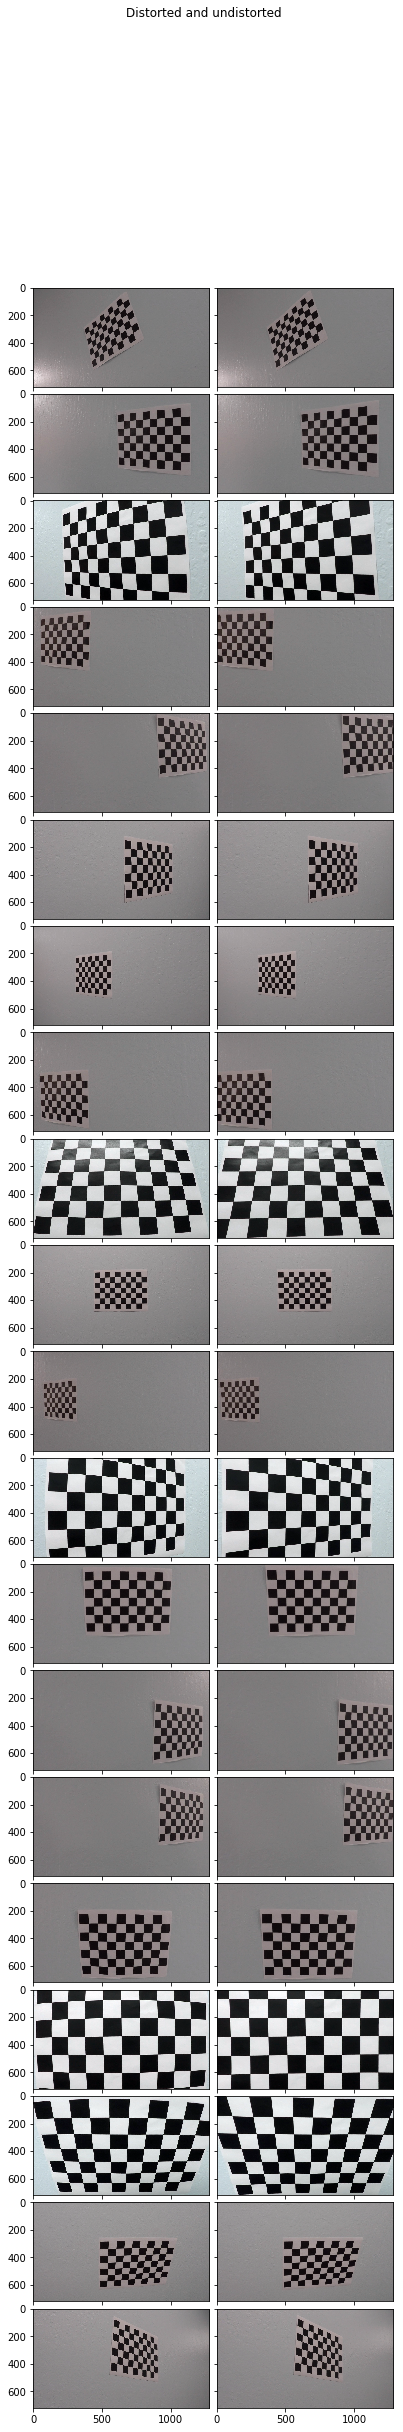

In [45]:
draw_grid(checkerboard_display_imgs, "Distorted and undistorted", img.shape[:2], 2, 10)

## And so on and so forth...

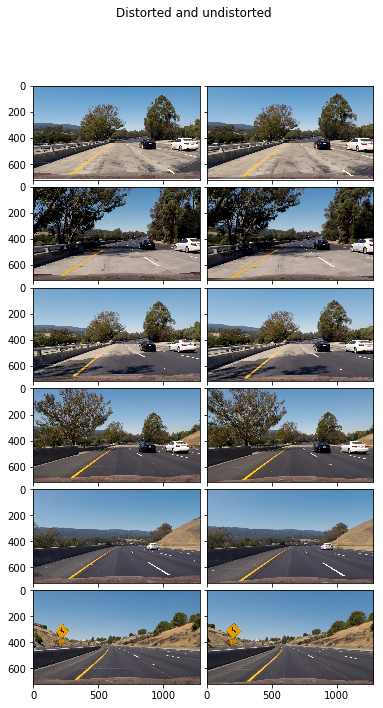

In [46]:
test_images = glob.glob('./test_images/test*.jpg')

test_images_display = []
for img in read_images(test_images):
    test_images_display.append(toRGB(img))
    undistorted = camera.undistort(img, False)
    test_images_display.append(toRGB(undistorted))
    
draw_grid(test_images_display, "Distorted and undistorted", test_images_display[0].shape[:2], 2, 10)

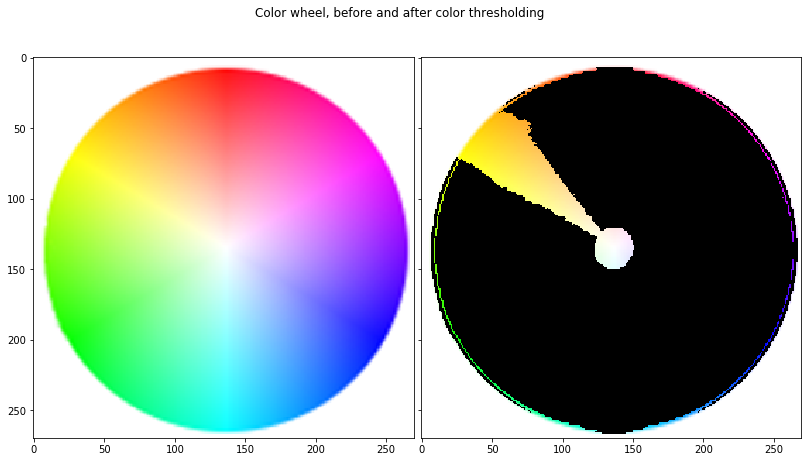

100%|██████████| 6/6 [00:00<00:00, 13.15it/s]


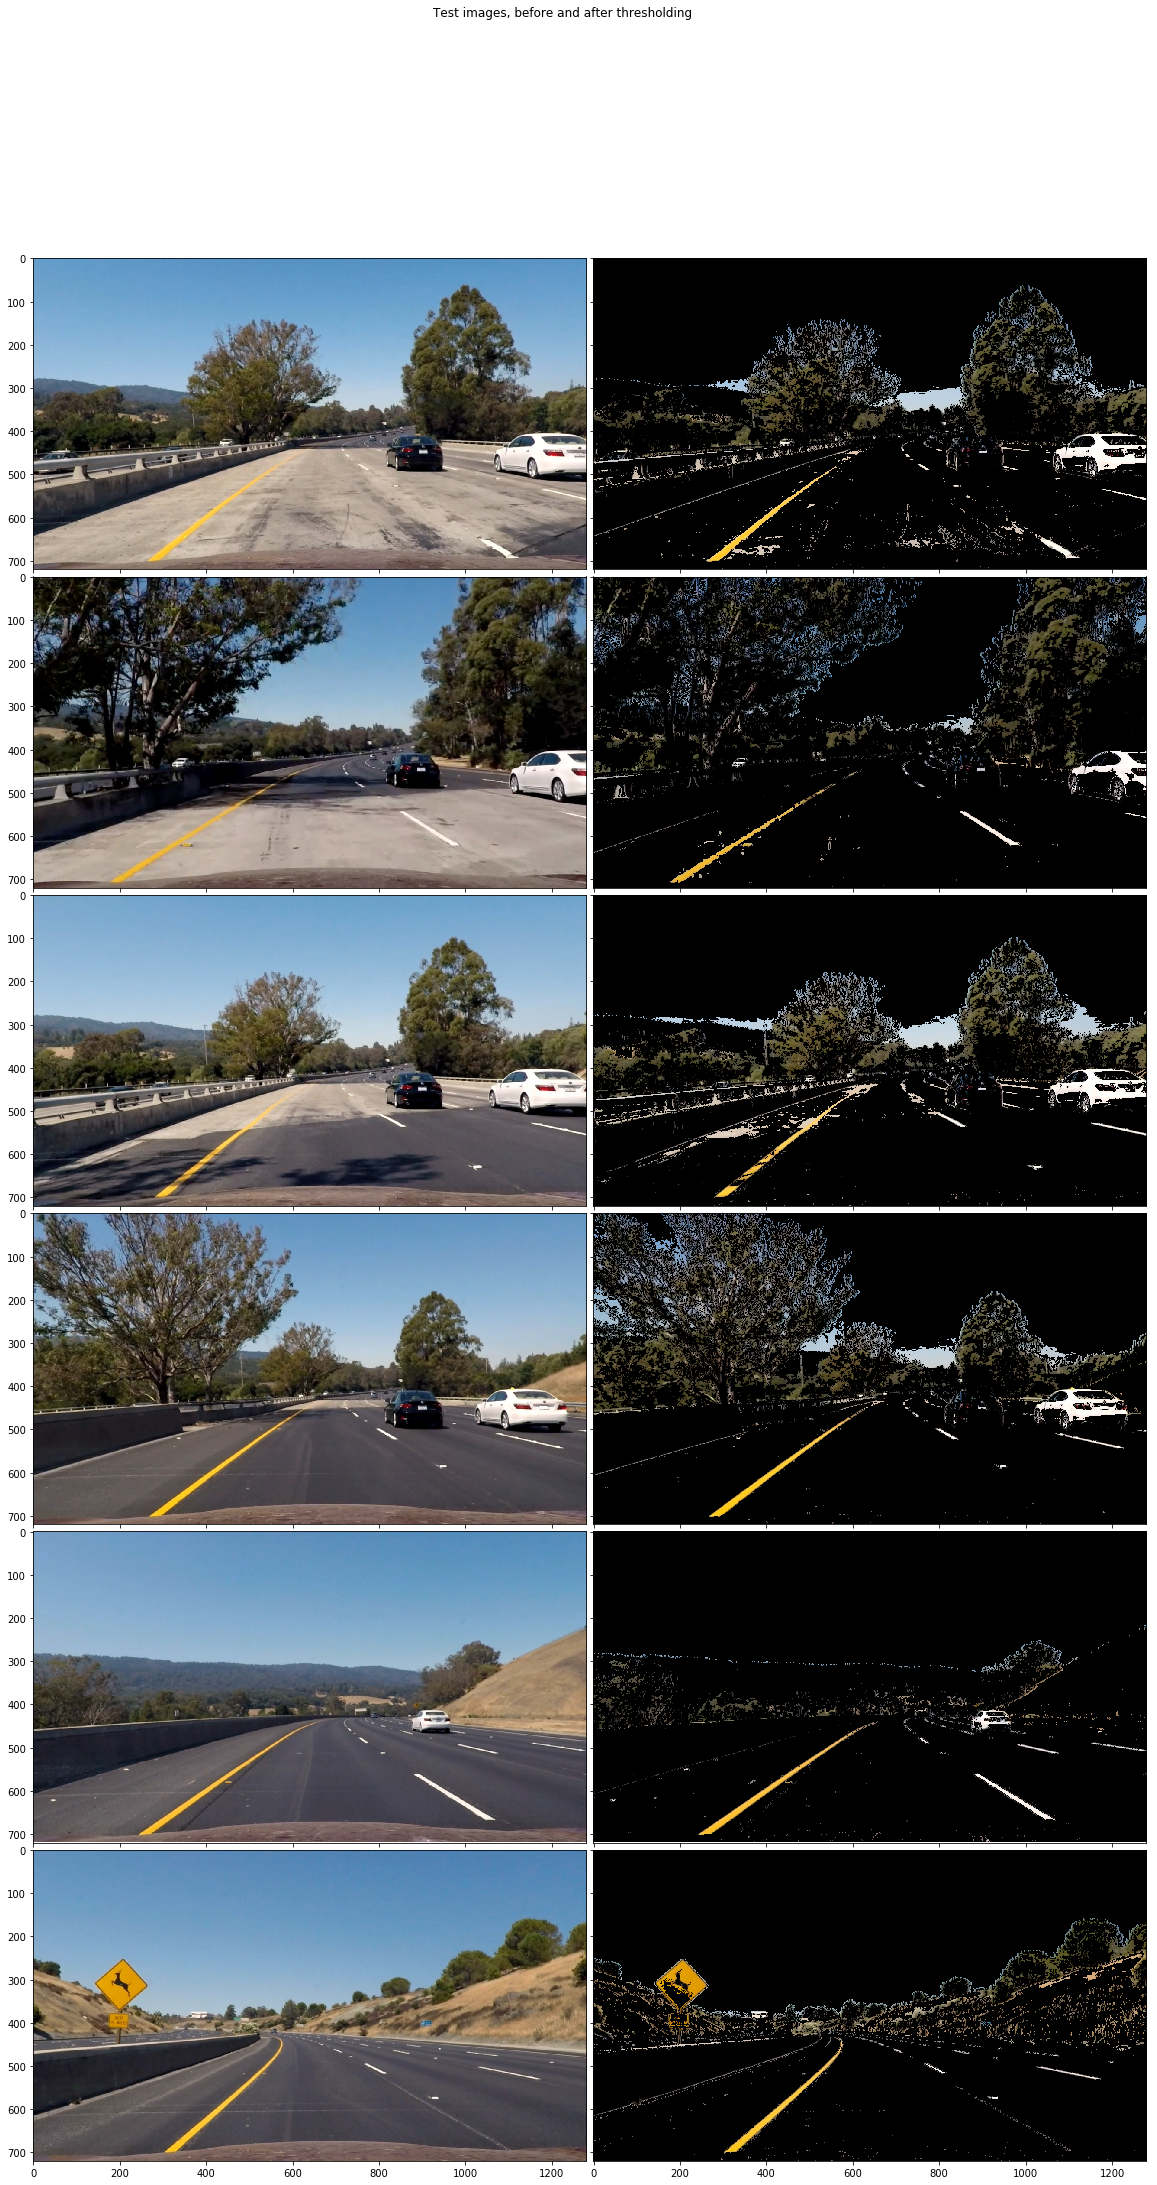

In [50]:
   

color_wheel = read_images(glob.glob('./examples/color-wheel.png'))
draw_grid([toRGB(color_wheel[0]), camera.color_crop_img(toRGB(color_wheel[0]), True)[0]],
         "Color wheel, before and after color thresholding", color_wheel[0].shape[:2], 2, 20)

sample_images = []

for img in tqdm(read_images(test_images)):
    img_undistorted = camera.undistort(toRGB(img), False)
    sample_images.append(img_undistorted)
    sample_images.append(camera.color_crop_img(img_undistorted, True)[0])
draw_grid(sample_images, "Test images, before and after thresholding", sample_images[0].shape[:2], 2, 30)


100%|██████████| 6/6 [00:00<00:00, 21.51it/s]


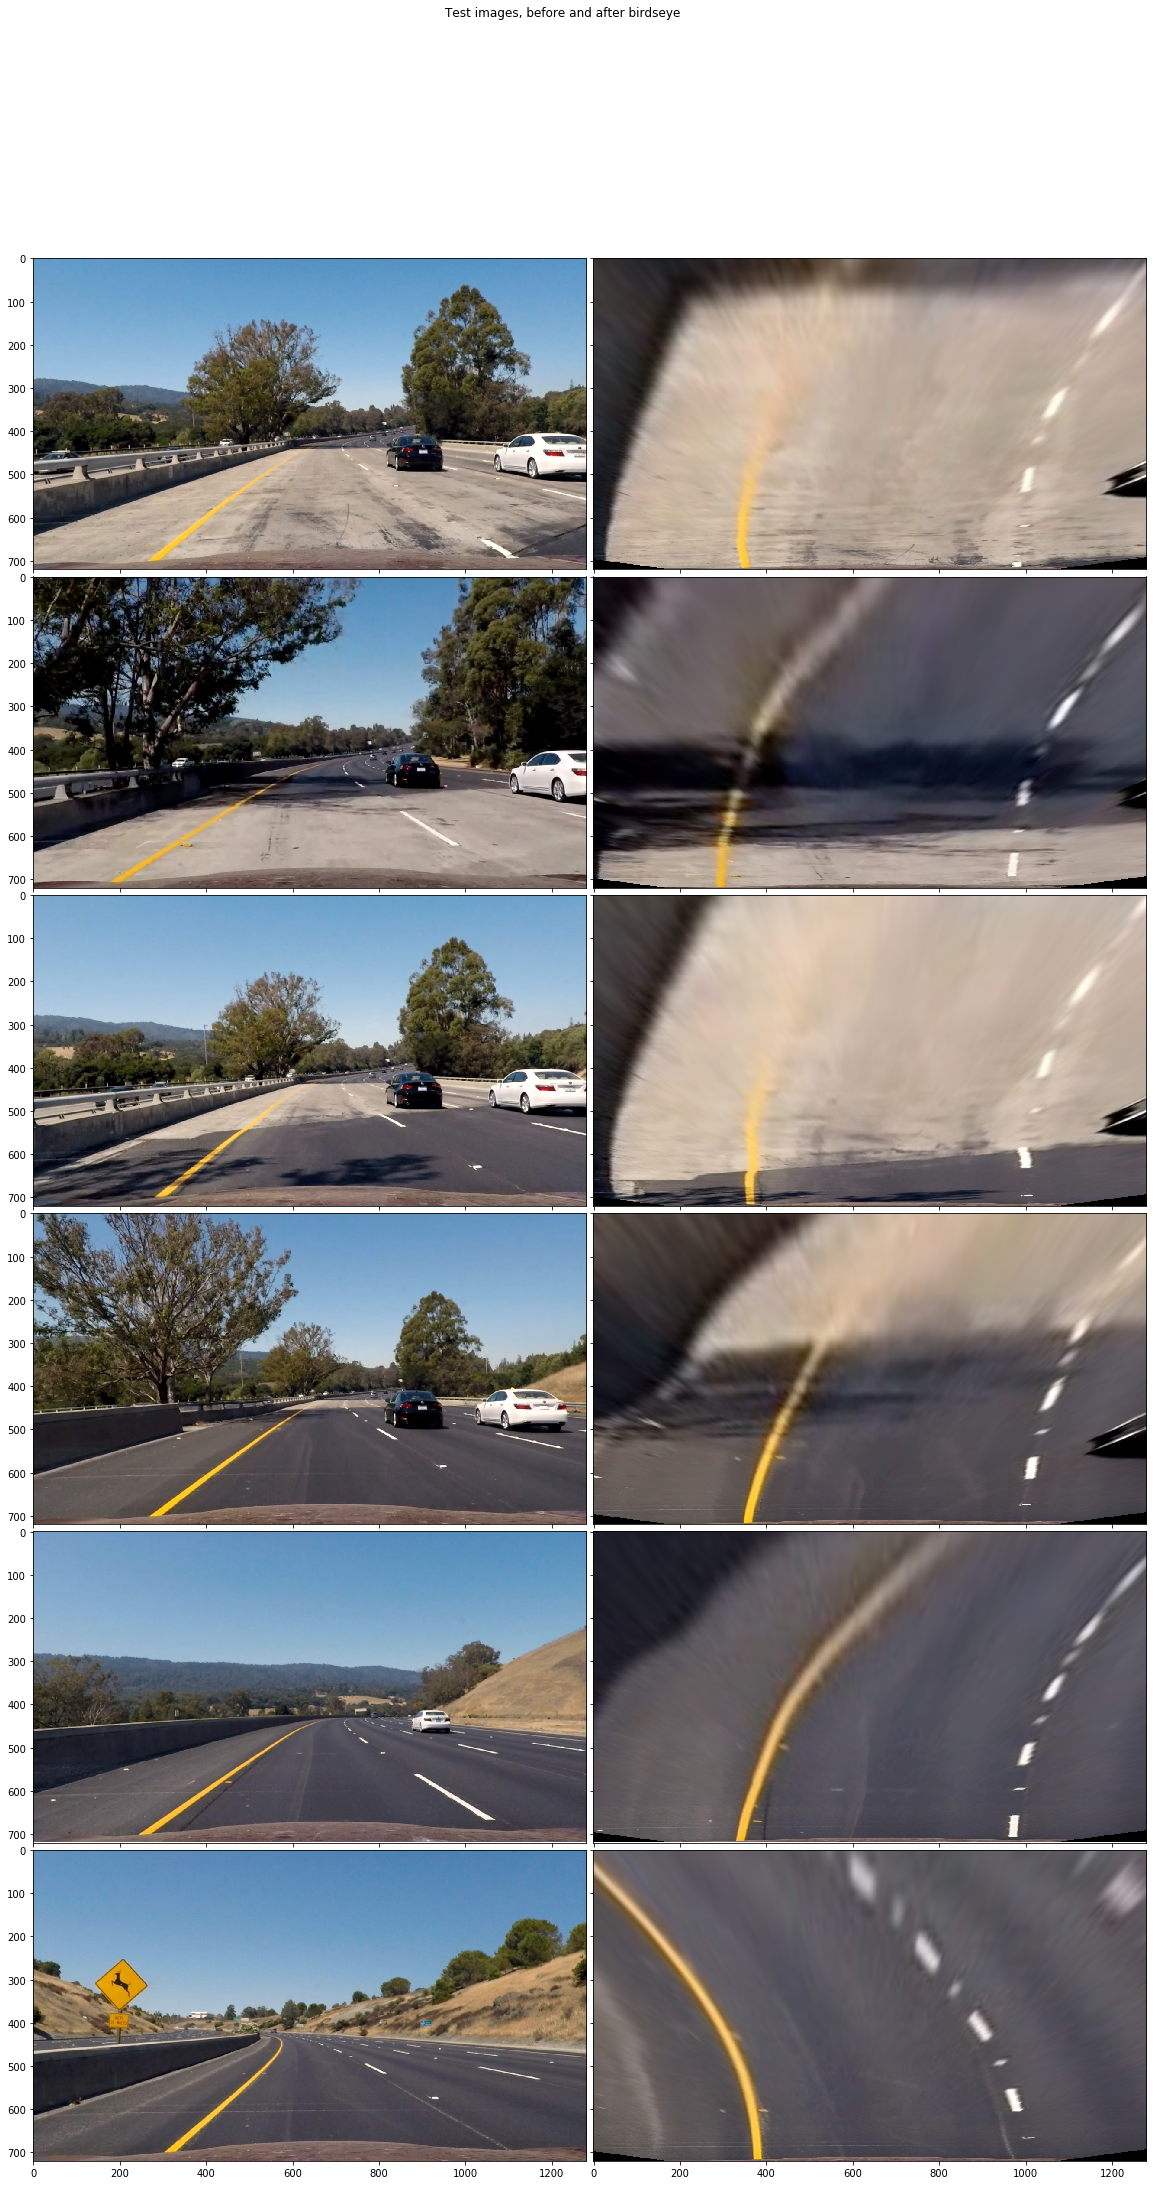

In [63]:


birdseye_images = []

for img in tqdm(read_images(test_images)):
    img_undistorted = camera.undistort(toRGB(img), False)
    birdseye_images.append(img_undistorted)
    birdseye_images.append(camera.birdseye_transform(img_undistorted))
draw_grid(birdseye_images, "Test images, before and after birdseye", birdseye_images[0].shape[:2], 2, 30)



In [57]:
# From https://carnd-forums.udacity.com/questions/32706990/want-to-create-a-diagnostic-view-into-your-lane-finding-pipeline
def normalized(img):
    return np.uint8(255*img/np.max(np.absolute(img)))

def to_RGB(img):
   if img.ndim == 2:
       img_normalized = normalized(img)
       return np.dstack((img_normalized, img_normalized, img_normalized))
   elif img.ndim == 3:
       return img
   else:
       return None

def compose_diagScreen(curverad=0, offset=0, mainDiagScreen=None,
                     diag1=None, diag2=None, diag3=None, diag4=None, diag5=None, diag6=None, diag7=None, diag8=None, diag9=None):
      # middle panel text example
      # using cv2 for drawing text in diagnostic pipeline.
      font = cv2.FONT_HERSHEY_COMPLEX
      middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
      cv2.putText(middlepanel, 'Estimated lane curvature: {}'.format(curverad), (30, 60), font, 1, (255,0,0), 2)
      cv2.putText(middlepanel, 'Estimated Meters right of center: {}'.format(offset), (30, 90), font, 1, (255,0,0), 2)

      # assemble the screen example
      diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
      if mainDiagScreen is not None:
            diagScreen[0:720, 0:1280] = mainDiagScreen
      if diag1 is not None:
            diagScreen[0:240, 1280:1600] = cv2.resize(to_RGB(diag1), (320,240), interpolation=cv2.INTER_AREA) 
      if diag2 is not None:
            diagScreen[0:240, 1600:1920] = cv2.resize(to_RGB(diag2), (320,240), interpolation=cv2.INTER_AREA)
      if diag3 is not None:
            diagScreen[240:480, 1280:1600] = cv2.resize(to_RGB(diag3), (320,240), interpolation=cv2.INTER_AREA)
      if diag4 is not None:
            diagScreen[240:480, 1600:1920] = cv2.resize(to_RGB(diag4), (320,240), interpolation=cv2.INTER_AREA)*4
      if diag5 is not None:
            diagScreen[600:1080, 1280:1920] = cv2.resize(to_RGB(diag5), (640,480), interpolation=cv2.INTER_AREA)*4
      diagScreen[720:840, 0:1280] = middlepanel
      if diag6 is not None:
            diagScreen[840:1080, 0:320] = cv2.resize(to_RGB(diag6), (320,240), interpolation=cv2.INTER_AREA)
      if diag7 is not None:
            diagScreen[840:1080, 320:640] = cv2.resize(to_RGB(diag7), (320,240), interpolation=cv2.INTER_AREA)
      if diag8 is not None:
            diagScreen[840:1080, 640:960] = cv2.resize(to_RGB(diag8), (320,240), interpolation=cv2.INTER_AREA)
      if diag9 is not None:
            diagScreen[840:1080, 960:1280] = cv2.resize(to_RGB(diag9), (320,240), interpolation=cv2.INTER_AREA)

      return diagScreen

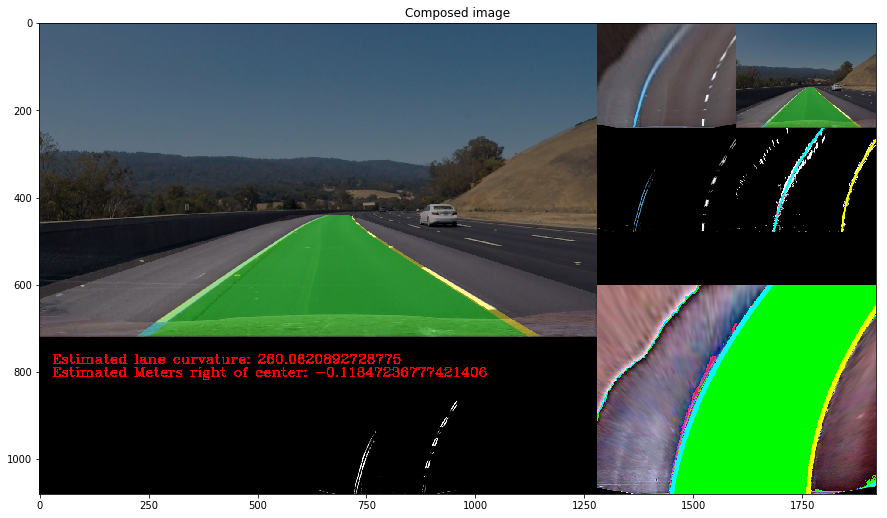

In [58]:
class Lane():
    def __init__(self):
        self.left = Line()
        self.right = Line()
        self.radius = None
        self.offset = None
        
    def detect(self, img, draw=False):
        birdseye_img = camera.birdseye_transform(camera.undistort(img))
        processed_img = camera.process(img)
        overlay = birdseye_img.copy()
        final_img, left_fitx, right_fitx = self.fit_lanes(processed_img.copy())
        
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))
        self.left.draw(overlay, (0, 255, 255))
        self.right.draw(overlay, (255, 255, 0))
        
        l_rad, l_offset = self.left.get_rad_offset()
        r_rad, r_offset = self.right.get_rad_offset()
        
        self.radius = (l_rad + r_rad)/2
        self.offset = (l_offset + r_offset)/2
        
        cv2.addWeighted(camera.birdseye_inverse(overlay), 0.4, toRGB(img), 0.6, 0, img)
        
        thresh, mask1, mask2, mask3 = camera.color_crop_img(birdseye_img, True)
        composed_img = compose_diagScreen(self.radius, self.offset, img, birdseye_img, img, 
                                         thresh, final_img, overlay, 
                                         mask1, mask2, mask3)
            
        if draw == True:
            draw_image(composed_img, "Composed image")
        
        return composed_img

    def fit_lanes(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        self.left.update(leftx, lefty)
        self.right.update(rightx, righty)
        
        l_img, l_fitx = self.left.draw(out_img, (0, 255, 255))
        r_img, r_fitx = self.right.draw(out_img, (255, 255, 0))
       
        return out_img, l_fitx, r_fitx
        
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def get_rad_offset(self):
        return self.radius_of_curvature, self.line_base_pos
        
    def update(self, xs, ys):
        # Fit a second order polynomial to each
        self.allx = xs
        self.ally = ys
        self.current_fit = np.polyfit(ys, xs, 2)
        
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        y_eval = 719
        fit_cr = np.polyfit(ys*ym_per_pix, xs*xm_per_pix, 2)
        # Calculate the new radii of curvature
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        # Now our radius of curvature is in meters
        #print("Curve:", curverad, 'm')
        self.radius_of_curvature = curverad
        
        self.line_base_pos = (350 + ((self.current_fit[0]*y_eval)**2 + self.current_fit[1]*y_eval + fit_cr[2])/2)*xm_per_pix
        #print("Base:", self.line_base_pos, 'm')
 
        
    def draw(self, img, color):
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]
        
        cv2.polylines(img, [np.int_(list(zip(fitx, ploty)))], False, color, 20)
        return img, fitx
       
lane = Lane()
foo = lane.detect(cv2.imread(test_images[4]), True)
        


In [59]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_video(input_path, output_path):
    lane = Lane()
    clip = VideoFileClip(input_path)
    output_clip = clip.fl_image(lambda x: lane.detect(toRGB(x), False))
    output_clip.write_videofile(output_path, audio=False)
    
process_video("project_video.mp4", "project_video_out.mp4")

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [06:03<00:00,  3.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_out.mp4"))